In [2]:
!curl -o train.tsv https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv
!curl -o test.tsv https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  703k  100  703k    0     0  1586k      0 --:--:-- --:--:-- --:--:-- 1635k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  184k  100  184k    0     0  1396k      0 --:--:-- --:--:-- --:--:-- 1486k


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [4]:
# Load .tsv files
train_df = pd.read_csv("train.tsv", sep='\t')
test_df = pd.read_csv("test.tsv", sep='\t')


train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Check results
print("Training set:", train_data.shape)
print("Validation set:", val_data.shape)


Training set: (5535, 2)
Validation set: (1384, 2)


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Load with column names manually set
train_df = pd.read_csv("train.tsv", sep='\t', header=None, names=["sentence", "label"])
test_df = pd.read_csv("test.tsv", sep='\t', header=None, names=["sentence", "label"])

# Split 20% for validation
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Initialize Bag-of-Words vectorizer
vectorizer = CountVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_data['sentence']).toarray()
X_val = vectorizer.transform(val_data['sentence']).toarray()
y_train = train_data['label'].values
y_val = val_data['label'].values

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (5536, 10000)
X_val shape: (1384, 10000)


# Designing Model

In [6]:
import torch.nn as nn
import torch


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_1=512,hidden_2=256,hidden_3=128,hidden_4=64, output_dim=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, hidden_4)
        self.fc5 = nn.Linear(hidden_4, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)    
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        return x



# Making model and count the parameter

In [10]:
model = MLP(input_dim=10000)

# Count trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {num_params:,}")


"""
(10000 * 512 + 512) = 5,120,512
(512 * 256 + 256)   =   131,328
(256 * 128 + 128)   =    32,896
(128 * 64 + 64)     =     8,256
(64 * 2 + 2)        =       130
----------------------------
Total               = 5,293,122

# 5,293,122 trainable parameters
"""


Total trainable parameters: 5,293,122


'\n(10000 * 512 + 512) = 5,120,512\n(512 * 256 + 256)   =   131,328\n(256 * 128 + 128)   =    32,896\n(128 * 64 + 64)     =     8,256\n(64 * 2 + 2)        =       130\n----------------------------\nTotal               = 5,293,122\n\n# 5,293,122 trainable parameters\n'

# Training the Model

Epoch 1 | Train Loss: 0.6186 | Val Loss: 10.2053 | Val Acc: 79.77%
Epoch 2 | Train Loss: 0.2971 | Val Loss: 10.8675 | Val Acc: 79.99%
Epoch 3 | Train Loss: 0.0889 | Val Loss: 14.1575 | Val Acc: 80.56%
Epoch 4 | Train Loss: 0.0224 | Val Loss: 21.7217 | Val Acc: 79.34%
Epoch 5 | Train Loss: 0.0082 | Val Loss: 28.6765 | Val Acc: 80.27%
Epoch 6 | Train Loss: 0.0025 | Val Loss: 37.2083 | Val Acc: 79.41%
Epoch 7 | Train Loss: 0.0003 | Val Loss: 43.7808 | Val Acc: 79.19%
Epoch 8 | Train Loss: 0.0002 | Val Loss: 49.6720 | Val Acc: 79.19%
Epoch 9 | Train Loss: 0.0001 | Val Loss: 59.6675 | Val Acc: 78.83%
Epoch 10 | Train Loss: 0.0125 | Val Loss: 40.0843 | Val Acc: 78.68%


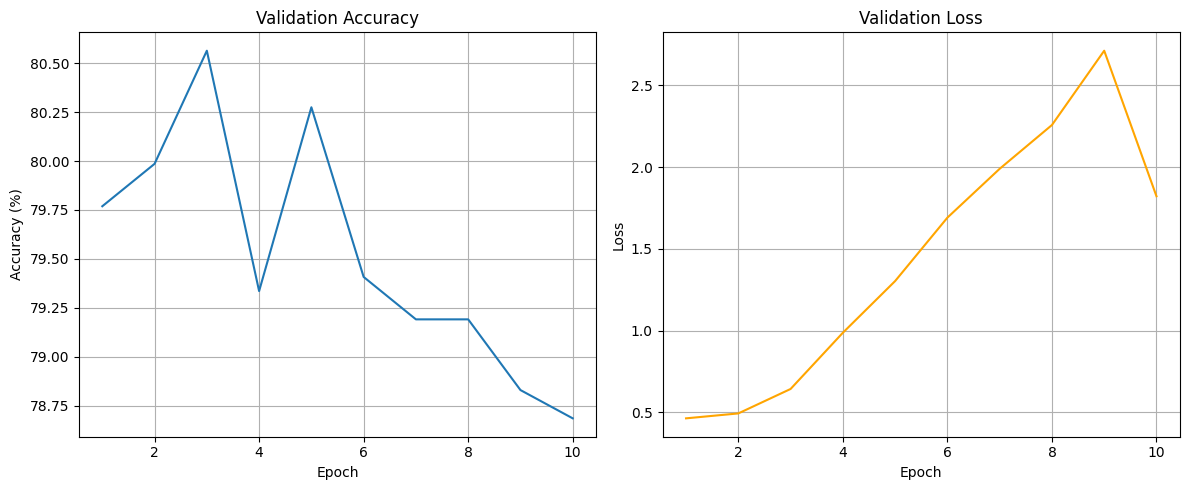

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Prepare data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Model, loss, optimizer
input_dim = X_train.shape[1]
model = MLP(input_dim=input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
best_val_acc = 0.0
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    acc = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.2f}%")

    # Save best model
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), "checkpoint.pt")

# Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, 11), val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(range(1, 11), val_losses, label="Val Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import time
import os

model_fp32 = MLP(input_dim=input_dim)
model_fp32.load_state_dict(torch.load("checkpoint.pt"))
model_fp32.eval()


torch.save(model_fp32.state_dict(), "original_model.pt")
size_original_mb = os.path.getsize("original_model.pt") / (1024 * 1024)

# Inference
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
start = time.time()
with torch.no_grad():
    outputs = model_fp32(X_val_tensor)
    preds = torch.argmax(outputs, dim=1)
inference_time_ms = (time.time() - start) * 1000

# Accuracy
correct = (preds == torch.tensor(y_val)).sum().item()
accuracy_fp32 = 100 * correct / len(y_val)

print("Original Model Results:")
print(f"Accuracy: {accuracy_fp32:.2f}%")
print(f"Model Size: {size_original_mb:.2f} MB")
print(f"Inference Time: {inference_time_ms:.2f} ms")

# Number of parameters
num_params_fp32 = sum(p.numel() for p in model_fp32.parameters() if p.requires_grad)    
print(f"Number of parameters: {num_params_fp32:,}")


Original Model Results:
Accuracy: 80.56%
Model Size: 20.20 MB
Inference Time: 58.56 ms
Number of parameters: 5,293,122


C:\Users\Parth\AppData\Local\Temp\ipykernel_20524\2652459993.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fp32.load_state_dict(torch.load("checkpoint.pt"))


In [13]:
import torch
import torch.nn as nn
import time
import os

model_fp32 = MLP(input_dim=input_dim)
model_fp32.load_state_dict(torch.load("checkpoint.pt"))
model_fp32.eval()

# Apply dynamic quantization (INT8, not INT4)
model_dynamic = torch.quantization.quantize_dynamic(
    model_fp32, {nn.Linear}, dtype=torch.qint8
)

torch.save(model_dynamic.state_dict(), "dynamic_quantized.pt")
size_dynamic_mb = os.path.getsize("dynamic_quantized.pt") / (1024 * 1024)

# Inference
X_val_tensor_q = torch.tensor(X_val, dtype=torch.float32)
start = time.time()
with torch.no_grad():
    outputs = model_dynamic(X_val_tensor_q)
    preds = torch.argmax(outputs, dim=1)
inference_time_ms = (time.time() - start) * 1000

# Accuracy
correct = (preds == torch.tensor(y_val)).sum().item()
accuracy = 100 * correct / len(y_val)

print("Dynamic Quantization Results:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Model Size: {size_dynamic_mb:.2f} MB")
print(f"Inference Time: {inference_time_ms:.2f} ms")

# Number of parameters
num_params_dynamic = sum(p.numel() for p in model_dynamic.parameters() if p.requires_grad)
print(f"Total trainable parameters (dynamic): {num_params_dynamic:,}")

C:\Users\Parth\AppData\Local\Temp\ipykernel_20524\3662412616.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fp32.load_state_dict(torch.load("checkpoint.pt"))


Dynamic Quantization Results:
Accuracy: 80.49%
Model Size: 5.06 MB
Inference Time: 94.78 ms
Total trainable parameters (dynamic): 0


In [14]:
model_fp32 = MLP(input_dim=input_dim)
model_fp32.load_state_dict(torch.load("checkpoint.pt"))
model_fp16 = model_fp32.half()
model_fp16.eval()

X_val_tensor_fp16 = torch.tensor(X_val, dtype=torch.float16)


start = time.time()
with torch.no_grad():
    outputs = model_fp16(X_val_tensor_fp16)
    preds = torch.argmax(outputs, dim=1)
inference_time_fp16 = (time.time() - start) * 1000

# Accuracy
correct = (preds == torch.tensor(y_val)).sum().item()
accuracy_fp16 = 100 * correct / len(y_val)

torch.save(model_fp16.state_dict(), "half_precision.pt")
size_fp16_mb = os.path.getsize("half_precision.pt") / (1024 * 1024)

print("Half Precision Results:")
print(f"Accuracy: {accuracy_fp16:.2f}%")
print(f"Model Size: {size_fp16_mb:.2f} MB")
print(f"Inference Time: {inference_time_fp16:.2f} ms")
# Number of parameters
num_params_fp16 = sum(p.numel() for p in model_fp16.parameters() if p.requires_grad)
print(f"Total trainable parameters (FP16): {num_params_fp16:,}")


C:\Users\Parth\AppData\Local\Temp\ipykernel_20524\1512094581.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fp32.load_state_dict(torch.load("checkpoint.pt"))


Half Precision Results:
Accuracy: 80.56%
Model Size: 10.10 MB
Inference Time: 14319.69 ms
Total trainable parameters (FP16): 5,293,122
